In [8]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from plotnine import ggplot, aes, geom_point, geom_abline, geom_hline, labs, theme_light

In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [5]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

In [10]:
#KNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

X = ha.drop(columns=["output"])
y = ha["output"]

categorical_features = ["sex", "cp", "restecg"]
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

def create_knn_pipeline(k):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


ks = range(1, 21)

#ChatGPT - Hyperparameter tuning: test different values of k
cv_roc_aucs = []
for k in ks:
    knn_pipeline = create_knn_pipeline(k)
    roc_auc = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()
    cv_roc_aucs.append((k, roc_auc))

# Find the best k
best_k, best_roc_auc = max(cv_roc_aucs, key=lambda x: x[1])

final_knn_pipeline = create_knn_pipeline(best_k)
final_knn_pipeline.fit(X_train, y_train)

y_pred = final_knn_pipeline.predict(X_test)
y_proba = final_knn_pipeline.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
classification_rep = classification_report(y_test, y_pred)

print(f"Best k: {best_k}")
print(f" ROC AUC for best k: {best_roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_rep)


Best k: 6
 ROC AUC for best k: 0.8500
Confusion Matrix:
[[26 12]
 [23 21]]
              precision    recall  f1-score   support

           0       0.53      0.68      0.60        38
           1       0.64      0.48      0.55        44

    accuracy                           0.57        82
   macro avg       0.58      0.58      0.57        82
weighted avg       0.59      0.57      0.57        82



In [12]:
#Q2: Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_cv_score = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()

logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

coefficients = logreg_pipeline.named_steps["logreg"].coef_
feature_names = logreg_pipeline.named_steps["preprocessor"].get_feature_names_out()
#ChatGPT - Coefficient CV
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients[0]})

print(f"Cross-validated ROC AUC: {logreg_cv_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)
print("\nFeature Coefficients:")
print(coef_df.sort_values(by="Coefficient", ascending=False))


Cross-validated ROC AUC: 0.8672
Confusion Matrix:
[[26 12]
 [ 8 36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        38
           1       0.75      0.82      0.78        44

    accuracy                           0.76        82
   macro avg       0.76      0.75      0.75        82
weighted avg       0.76      0.76      0.75        82


Feature Coefficients:
          Feature  Coefficient
5       cat__cp_1     1.684063
6       cat__cp_2     1.409925
3    num__thalach     0.877834
7       cat__cp_3     0.790841
8  cat__restecg_1     0.562695
9  cat__restecg_2    -0.007461
2       num__chol    -0.085833
1     num__trtbps    -0.166962
0        num__age    -0.264865
4      cat__sex_1    -1.595088


Chest pain type (cp) is the strongest predictor, with cp_1 and cp_2 having the largest positive associations.
Maximum heart rate (thalach) also has a notable positive influence on risk.
Variables like sex, age, and resting blood pressure show moderate to weak negative associations with risk in this dataset.

Best Tree Depth: 2
Cross-validated ROC AUC for best depth: 0.7928
Test ROC AUC: 0.6597
Confusion Matrix:
[[25 13]
 [16 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63        38
           1       0.68      0.64      0.66        44

    accuracy                           0.65        82
   macro avg       0.65      0.65      0.65        82
weighted avg       0.65      0.65      0.65        82



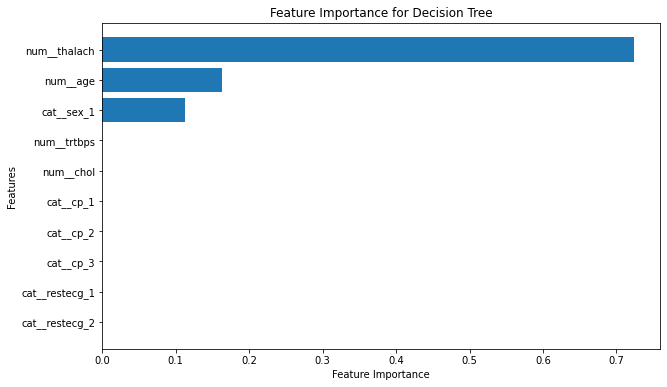

In [14]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

def create_decision_tree_pipeline(max_depth):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("decision_tree", DecisionTreeClassifier(max_depth=max_depth, random_state=42))
    ])

# Hyperparameter Tuning
depths = range(1, 21)
cv_roc_aucs = []

for depth in depths:
    dt_pipeline = create_decision_tree_pipeline(max_depth=depth)
    roc_auc = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()
    cv_roc_aucs.append((depth, roc_auc))

# Find the best depth
best_depth, best_roc_auc = max(cv_roc_aucs, key=lambda x: x[1])

final_dt_pipeline = create_decision_tree_pipeline(max_depth=best_depth)
final_dt_pipeline.fit(X_train, y_train)

y_pred = final_dt_pipeline.predict(X_test)
y_proba = final_dt_pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#ChatGPT - Feature Importance
tree_model = final_dt_pipeline.named_steps["decision_tree"]
feature_importances = tree_model.feature_importances_
feature_names = final_dt_pipeline.named_steps["preprocessor"].get_feature_names_out()
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)


print(f"Best Tree Depth: {best_depth}")
print(f"Cross-validated ROC AUC for best depth: {best_roc_auc:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

#ChatGPT - Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Decision Tree")
plt.gca().invert_yaxis()
plt.show()



Interpretation:
Chest pain type (cp_1, cp_2, cp_3) is the strongest predictor of heart attack risk.
Maximum heart rate achieved during exercise (thalach) is another critical feature.
Other features (age, sex, and cholesterol) have less consistent importance but may contribute indirectly or interact with stronger predictors.

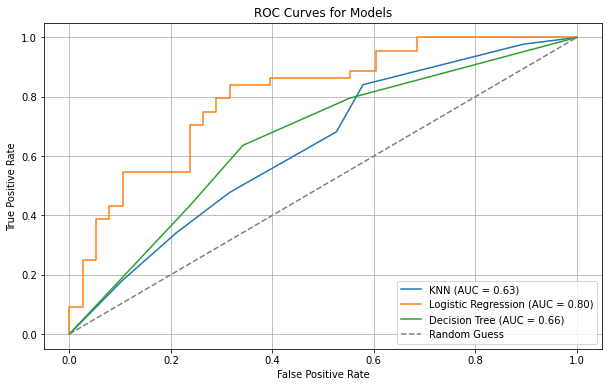

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    for name, model in models:
        y_proba = model.predict_proba(X_test)[:, 1]
        
        #ChatGPT - Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    #ChatGPT - Plot diagonal line for random guessing
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

models = [
    ("KNN", final_knn_pipeline),
    ("Logistic Regression", logreg_pipeline),
    ("Decision Tree", final_dt_pipeline),
]

plot_roc_curve(models, X_test, y_test)


In [17]:
#True Positive Rate or Recall or Sensitivity 
from sklearn.model_selection import cross_val_predict

models = [("KNN", final_knn_pipeline), 
          ("Logistic Regression", logreg_pipeline), 
          ("Decision Tree", final_dt_pipeline)]

for name, model in models:
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
    
    tp = sum((y_train == 1) & (y_pred_cv == 1))
    fn = sum((y_train == 1) & (y_pred_cv == 0))
    recall = tp / (tp + fn)
    
    print(f"{name} - True Positive Rate (Recall): {recall:.4f}")


KNN - True Positive Rate (Recall): 0.6471
Logistic Regression - True Positive Rate (Recall): 0.8333
Decision Tree - True Positive Rate (Recall): 0.6961


In [18]:
# Precision or Positive Predictive Value
for name, model in models:
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
    
    tp = sum((y_train == 1) & (y_pred_cv == 1))
    fp = sum((y_train == 0) & (y_pred_cv == 1))
    precision = tp / (tp + fp)
    
    print(f"{name} - Precision: {precision:.4f}")


KNN - Precision: 0.9041
Logistic Regression - Precision: 0.7870
Decision Tree - Precision: 0.7717


In [19]:
# True Negative Rate or Specificity or Negative Predictive Value
for name, model in models:
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
    
    tn = sum((y_train == 0) & (y_pred_cv == 0))
    fp = sum((y_train == 0) & (y_pred_cv == 1))
    specificity = tn / (tn + fp)
    
    print(f"{name} - True Negative Rate (Specificity): {specificity:.4f}")


KNN - True Negative Rate (Specificity): 0.9213
Logistic Regression - True Negative Rate (Specificity): 0.7416
Decision Tree - True Negative Rate (Specificity): 0.7640


Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.
Recommended Model: Logistic Regression (AUC = 0.80)
Reason:
Logistic Regression achieves the highest True Positive Rate (Recall) of 0.8333, minimizing false negatives better than KNN (0.6471) and Decision Tree (0.6961). It also maintains a reasonable Precision of 0.7870, ensuring that most patients predicted as at-risk are truly at risk.

Expected Performance:
Recall (True Positive Rate): ~83.33% (captures most at-risk patients).
Precision: ~78.70% (accurately identifies at-risk patients).
Final Recommendation:
To reduce lawsuits, prioritize Recall to identify as many at-risk patients as possible. Use the Logistic Regression model for its balance of high Recall and reasonable Precision.

Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.
Recommended Model: KNN (AUC = 0.63)
Reason:
KNN achieves the highest Precision (0.9041), ensuring that ~90% of patients predicted to be at risk are truly at risk. This minimizes unnecessary bed usage. While its Recall (0.6471) is lower, Precision aligns better with the hospital's priority.

Expected Performance:
Precision: ~90.41% (accurately identifies at-risk patients).
Recall: ~64.71% (captures most truly at-risk patients).
Final Recommendation:
To optimize bed space, prioritize Precision and use the KNN model to ensure only truly at-risk patients are monitored.

Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.
Recommended Model: Logistic Regression (AUC = 0.80)
Reason:
Logistic Regression provides interpretable coefficients, revealing the relationship between features and heart attack risk. Key predictors like cp_1 (typical angina) and thalach (heart rate) show strong associations.

Expected Performance:
AUC: ~0.80 (strong discrimination).
Key Predictors: cp_1, thalach, and other biological features.
Final Recommendation:
Use Logistic Regression to study root causes, as it offers clear insights into which biological measures contribute to heart attack risk.

Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.
Recommended Model: Decision Tree (AUC = 0.66)
Reason:
Decision Trees mimic human decision-making by creating easily interpretable, rule-based predictions. This makes it ideal for comparison with doctor diagnoses and provides straightforward insights into how predictions are made.

Expected Performance:
AUC: ~0.66 (moderate discrimination).
Key Feature: The model’s decision rules can directly compare to doctors’ diagnostic reasoning.
Final Recommendation:
Use the Decision Tree model to align predictions with human reasoning, making it easier to measure and train new doctors’ diagnostic abilities.

Part 4: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

In [22]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

# ChatGPT - Function to evaluate models with consistent preprocessing
def evaluate_model(name, model, X, y):
    y_pred = model.predict(X)  # Preprocessing happens within the pipeline
    y_proba = model.predict_proba(X)[:, 1]  # Preprocessing also applies here

    roc_auc = roc_auc_score(y, y_proba)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"{name}:")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("  Confusion Matrix:")
    print(conf_matrix)
    print()

models = [
    ("KNN", final_knn_pipeline),
    ("Logistic Regression", logreg_pipeline),
    ("Decision Tree", final_dt_pipeline),
]

for name, model in models:
    evaluate_model(name, model, X_val, y_val)  


KNN:
  ROC AUC: 0.8158
  Precision: 0.8462
  Recall: 0.5789
  Confusion Matrix:
[[ 9  2]
 [ 8 11]]

Logistic Regression:
  ROC AUC: 0.8469
  Precision: 0.8750
  Recall: 0.7368
  Confusion Matrix:
[[ 9  2]
 [ 5 14]]

Decision Tree:
  ROC AUC: 0.8421
  Precision: 0.9231
  Recall: 0.6316
  Confusion Matrix:
[[10  1]
 [ 7 12]]



Logistic Regression:
Performed consistently well, with both validation and cross-validated results aligning closely.
Maintains strong balance between precision and recall, making it a reliable model for generalization.

Decision Tree:
Surpassed cross-validated expectations in terms of ROC AUC and Precision.
Recall slightly decreased, but the model performed better than anticipated overall.

KNN:
Showed the largest discrepancy between cross-validated ROC AUC and validation ROC AUC, performing much better on the validation set.
Precision and Recall were slightly lower than expected.

Conclusion:
The cross-validated estimates generally aligned with the validation results, particularly for Logistic Regression and Decision Tree. However, KNN showed unexpected improvement in ROC AUC on the validation set. Overall, Logistic Regression remains the most reliable model, balancing all metrics effectively and generalizing well.

Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. 

In [23]:
# Definition: Cohen’s Kappa measures the level of agreement between a model’s predictions and the true class labels, adjusted for agreement that could happen by chance.
from sklearn.metrics import cohen_kappa_score

def evaluate_kappa(name, model, X, y):
    y_pred = model.predict(X)

    kappa = cohen_kappa_score(y, y_pred)
    
    print(f"{name} - Cohen's Kappa: {kappa:.4f}")

for name, model in models:
    evaluate_kappa(name, model, X_val, y_val)


KNN - Cohen's Kappa: 0.3562
Logistic Regression - Cohen's Kappa: 0.5249
Decision Tree - Cohen's Kappa: 0.4850


Do the Conclusions Change:
No, the conclusions from earlier analyses remain consistent
Logistic Regression is still the best-performing model overall, as it strikes the best balance between identifying true positives and avoiding false positives, reflected in the highest Kappa.
Decision Tree remains the second-best, with moderate performance across all metrics.
KNN is still the weakest model, with poor Recall dragging down its Kappa score despite strong Precision.

This makes sense, because Cohen’s Kappa penalizes imbalance in class predictions (e.g., low Recall or low Precision).
KNN’s struggles with Recall reduce its agreement with true labels, which is reflected in a low Kappa score.
Logistic Regression’s strong balance between Recall and Precision naturally leads to the highest Kappa, confirming its reliability.